In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import glob
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')
mpl.rcParams['savefig.dpi'] = 128
mpl.rcParams['figure.dpi'] = 128
# Plot size to 14" x 7"
mpl.rc('figure', figsize = (14, 7))
# Font size to 14
mpl.rc('font', size = 14)
# Do not display top and right frame lines
mpl.rc('axes.spines', top = False, right = False)
# Remove grid lines
mpl.rc('axes', grid = False)
# Set backgound color to white
mpl.rc('axes', facecolor = 'white')


# read whole year data
allFiles = glob.glob("data/*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
df = pd.concat(list_)

# df = pd.read_csv('data/marketing-breakdown-detailed (1).csv')

In [2]:
selected_features = ['Marketing Code','Suburb', 'State','Post Code','Classification','Enquired',
                     'Loan Amount','loan_reason','property_use']
target = 'Enquiry Status';
whole_set = selected_features + [target]

df = df[whole_set]
df = df.replace('On Hold','Rejected')
# convert loan amount to number type, and change string to NaN
df['Loan Amount'] = pd.to_numeric(df['Loan Amount'],errors='coerce')
df = df.dropna(axis=0, how='any')

df = df[~df[target].isin(['In Progress','Just Received'])]
df['Loan Amount'] = df['Loan Amount'].astype(int)

In [3]:
print("Shape of data frame: {}".format(df.shape))
print("Keys of enquiries_dataset: \n{}".format(df.keys()))

'P00019' in df['Marketing Code'].unique()
# df['Marketing Code'].unique()

Shape of data frame: (33807, 10)
Keys of enquiries_dataset: 
Index(['Marketing Code', 'Suburb', 'State', 'Post Code', 'Classification',
       'Enquired', 'Loan Amount', 'loan_reason', 'property_use',
       'Enquiry Status'],
      dtype='object')


True

In [4]:
from datetime import datetime
from dateutil.parser import parse

df['Enquired'] = pd.DatetimeIndex(df['Enquired'])
# df['Enquired'] = temp
# df['Enquired Date'] = pd.to_datetime(temp.date)
# df['Enquired Time'] = temp.time
# data_set = data_set.drop(['Enquired'],1)

# filter years
start_date = '2017-01-01' 
end_date = '2017-12-31'
mask = (df['Enquired'] > start_date) & (df['Enquired'] <= end_date)
df = df.loc[mask].reset_index(drop=True)
df['Year'] = df['Enquired'].dt.year
df['Month'] = df['Enquired'].dt.month
df['Day'] = df['Enquired'].dt.day
df['hour'] = df['Enquired'].dt.hour
df['Weekday'] = df['Enquired'].dt.weekday_name

# if 'Enquired' in df.columns:
#     df = df.drop(columns=['Enquired'])
#     df = df.drop(columns=['Enquired Date'])



In [5]:
encoded_columns = df.loc[:, df.columns != 'Loan Amount'].columns

In [6]:
print("List of data types: \n{}".format(df.dtypes))

List of data types: 
Marketing Code            object
Suburb                    object
State                     object
Post Code                float64
Classification            object
Enquired          datetime64[ns]
Loan Amount                int64
loan_reason               object
property_use              object
Enquiry Status            object
Year                       int64
Month                      int64
Day                        int64
hour                       int64
Weekday                   object
dtype: object


In [7]:
from sklearn.preprocessing import LabelEncoder

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col].astype(str))
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [8]:
class MultiColumnLabelEncoder(LabelEncoder):
    """
    Wraps sklearn LabelEncoder functionality for use on multiple columns of a
    pandas dataframe.

    """
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, dframe):
        """
        Fit label encoder to pandas columns.

        Access individual column classes via indexig `self.all_classes_`

        Access individual column encoders via indexing
        `self.all_encoders_`
        """
        # if columns are provided, iterate through and get `classes_`
        if self.columns is not None:
            # ndarray to hold LabelEncoder().classes_ for each
            # column; should match the shape of specified `columns`
            self.all_classes_ = np.ndarray(shape=self.columns.shape,
                                           dtype=object)
            self.all_encoders_ = np.ndarray(shape=self.columns.shape,
                                            dtype=object)
            for idx, column in enumerate(self.columns):
                # fit LabelEncoder to get `classes_` for the column
                le = LabelEncoder()
                le.fit(dframe.loc[:, column].values)
                # append the `classes_` to our ndarray container
                self.all_classes_[idx] = (column,
                                          np.array(le.classes_.tolist(),
                                                  dtype=object))
                # append this column's encoder
                self.all_encoders_[idx] = le
        else:
            # no columns specified; assume all are to be encoded
            self.columns = dframe.iloc[:, :].columns
            self.all_classes_ = np.ndarray(shape=self.columns.shape,
                                           dtype=object)
            for idx, column in enumerate(self.columns):
                le = LabelEncoder()
                le.fit(dframe.loc[:, column].values)
                self.all_classes_[idx] = (column,
                                          np.array(le.classes_.tolist(),
                                                  dtype=object))
                self.all_encoders_[idx] = le
        return self

    def fit_transform(self, dframe):
        """
        Fit label encoder and return encoded labels.

        Access individual column classes via indexing
        `self.all_classes_`

        Access individual column encoders via indexing
        `self.all_encoders_`

        Access individual column encoded labels via indexing
        `self.all_labels_`
        """
        # if columns are provided, iterate through and get `classes_`
        if self.columns is not None:
            # ndarray to hold LabelEncoder().classes_ for each
            # column; should match the shape of specified `columns`
            self.all_classes_ = np.ndarray(shape=self.columns.shape,
                                           dtype=object)
            self.all_encoders_ = np.ndarray(shape=self.columns.shape,
                                            dtype=object)
            self.all_labels_ = np.ndarray(shape=self.columns.shape,
                                          dtype=object)
            for idx, column in enumerate(self.columns):
                # instantiate LabelEncoder
                le = LabelEncoder()
                # fit and transform labels in the column
                dframe.loc[:, column] =\
                    le.fit_transform(dframe.loc[:, column].values)
                # append the `classes_` to our ndarray container
                self.all_classes_[idx] = (column,
                                          np.array(le.classes_.tolist(),
                                                  dtype=object))
                self.all_encoders_[idx] = le
                self.all_labels_[idx] = le
        else:
            # no columns specified; assume all are to be encoded
            self.columns = dframe.iloc[:, :].columns
            self.all_classes_ = np.ndarray(shape=self.columns.shape,
                                           dtype=object)
            for idx, column in enumerate(self.columns):
                le = LabelEncoder()
                dframe.loc[:, column] = le.fit_transform(
                        dframe.loc[:, column].values)
                self.all_classes_[idx] = (column,
                                          np.array(le.classes_.tolist(),
                                                  dtype=object))
                self.all_encoders_[idx] = le
        return dframe

    def transform(self, dframe):
        """
        Transform labels to normalized encoding.
        """
        if self.columns is not None:
            for idx, column in enumerate(self.columns):
                dframe.loc[:, column] = self.all_encoders_[
                    idx].transform(dframe.loc[:, column].values)
        else:
            self.columns = dframe.iloc[:, :].columns
            for idx, column in enumerate(self.columns):
                dframe.loc[:, column] = self.all_encoders_[idx]\
                    .transform(dframe.loc[:, column].values)
        return dframe.loc[:, self.columns].values

    def inverse_transform(self, dframe):
        """
        Transform labels back to original encoding.
        """
        if self.columns is not None:
            for idx, column in enumerate(self.columns):
                dframe.loc[:, column] = self.all_encoders_[idx]\
                    .inverse_transform(dframe.loc[:, column].values)
        else:
            self.columns = dframe.iloc[:, :].columns
            for idx, column in enumerate(self.columns):
                dframe.loc[:, column] = self.all_encoders_[idx]\
                    .inverse_transform(dframe.loc[:, column].values)
        return dframe
    

In [9]:
mce = MultiColumnLabelEncoder(columns = encoded_columns);
mce.fit_transform(df)
# mce.transform(df)
# display(df)

X = df[df.keys()]
X = X.drop(['Enquiry Status'],1)
y = df[target]

In [10]:
from sklearn.model_selection import train_test_split

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                     test_size=0.4,
                     random_state=0,
                     stratify=y)

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


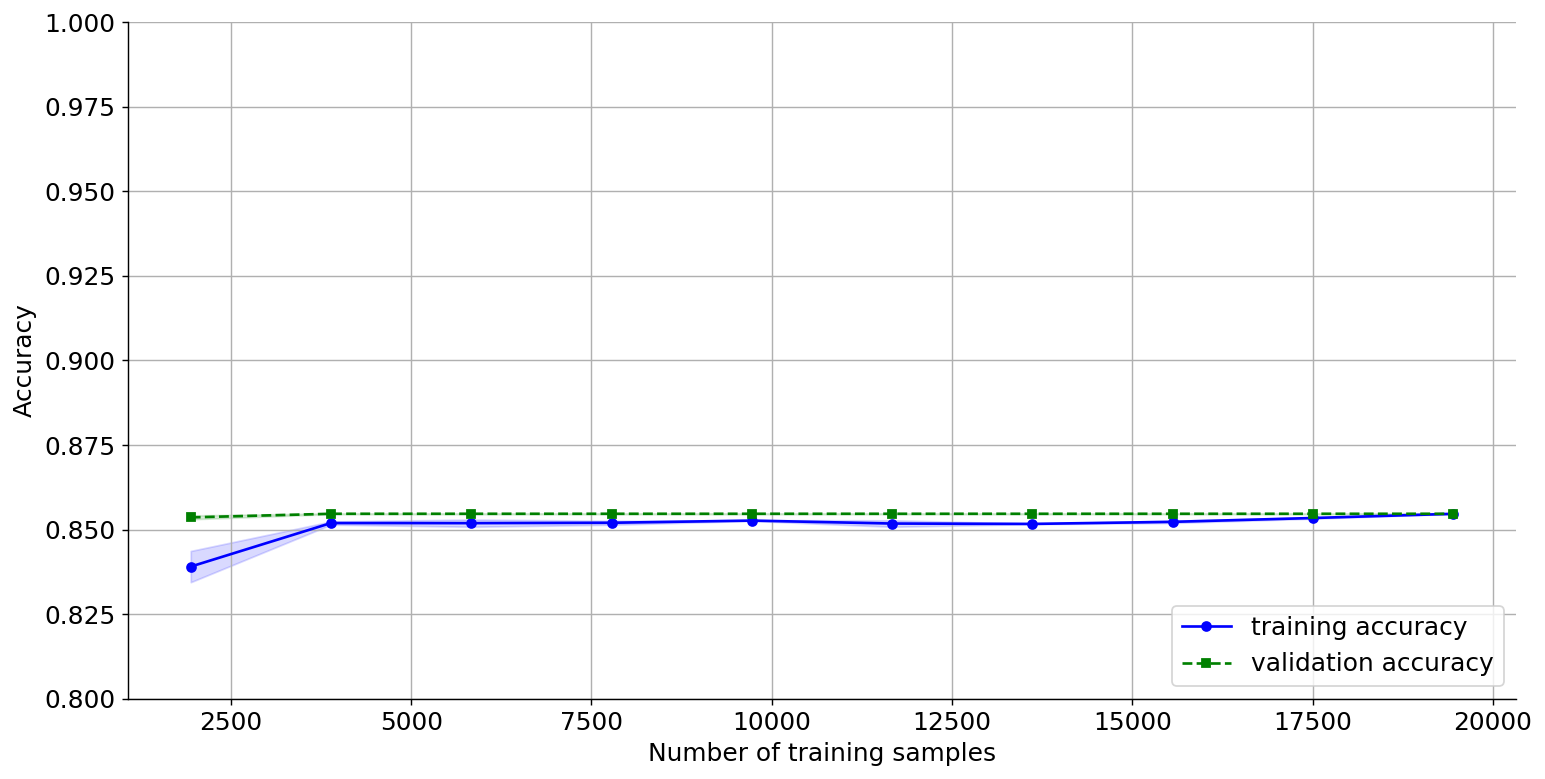

Test Accuracy: 0.855


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import learning_curve

pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(random_state=1))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,y=y_train,train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores, axis=1)      
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')               
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

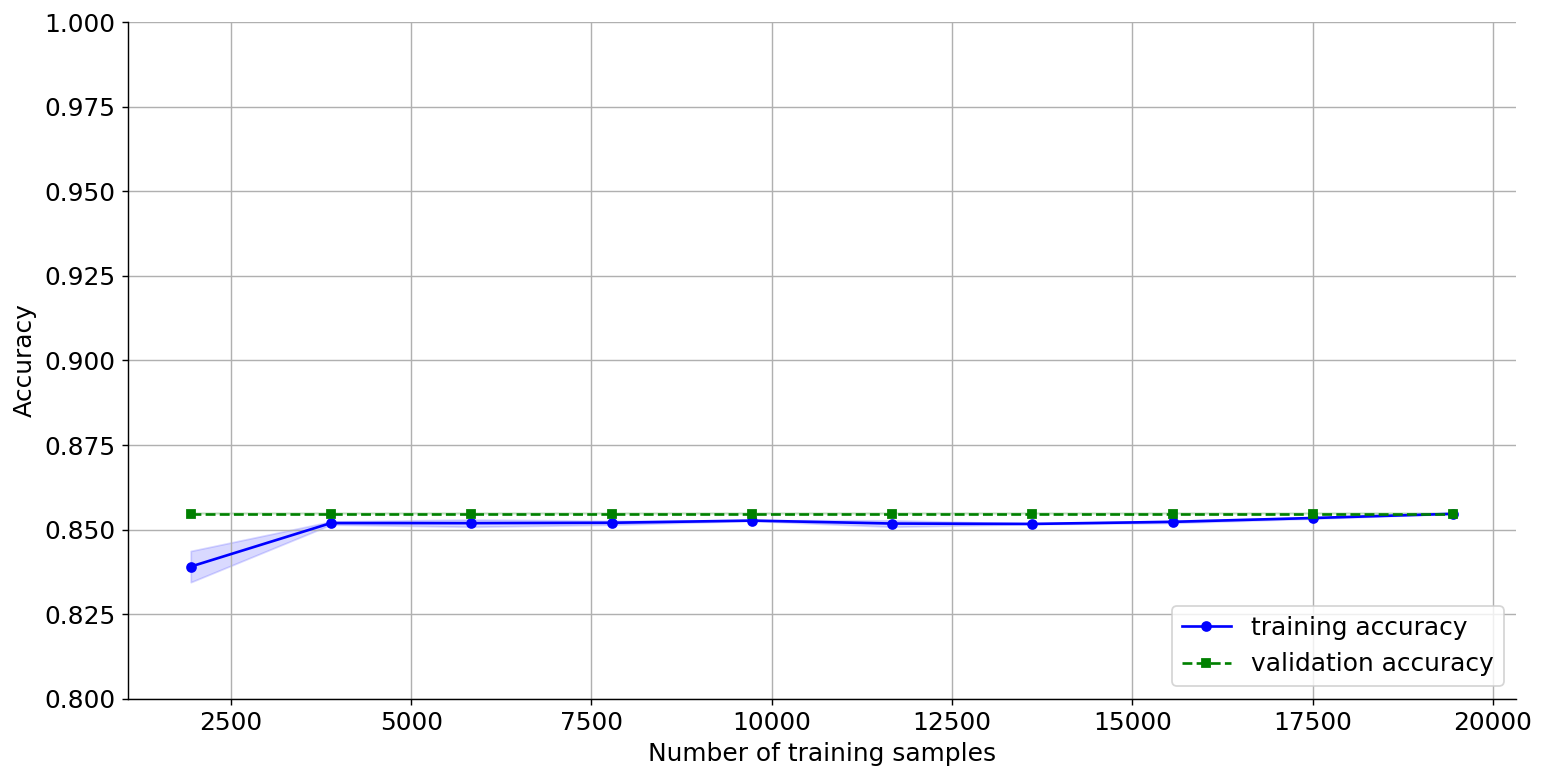

Test Accuracy: 0.855


In [12]:
from sklearn import svm

pipe_svm = make_pipeline(StandardScaler(),PCA(n_components=2),svm.SVC(C=0.1))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_svm,
                                                        X=X_train,y=y_train,train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores, axis=1)      
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')               
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

pipe_svm.fit(X_train, y_train)
y_svm_pred = pipe_svm.predict(X_test)
print('Test Accuracy: %.3f' % pipe_svm.score(X_test, y_test))

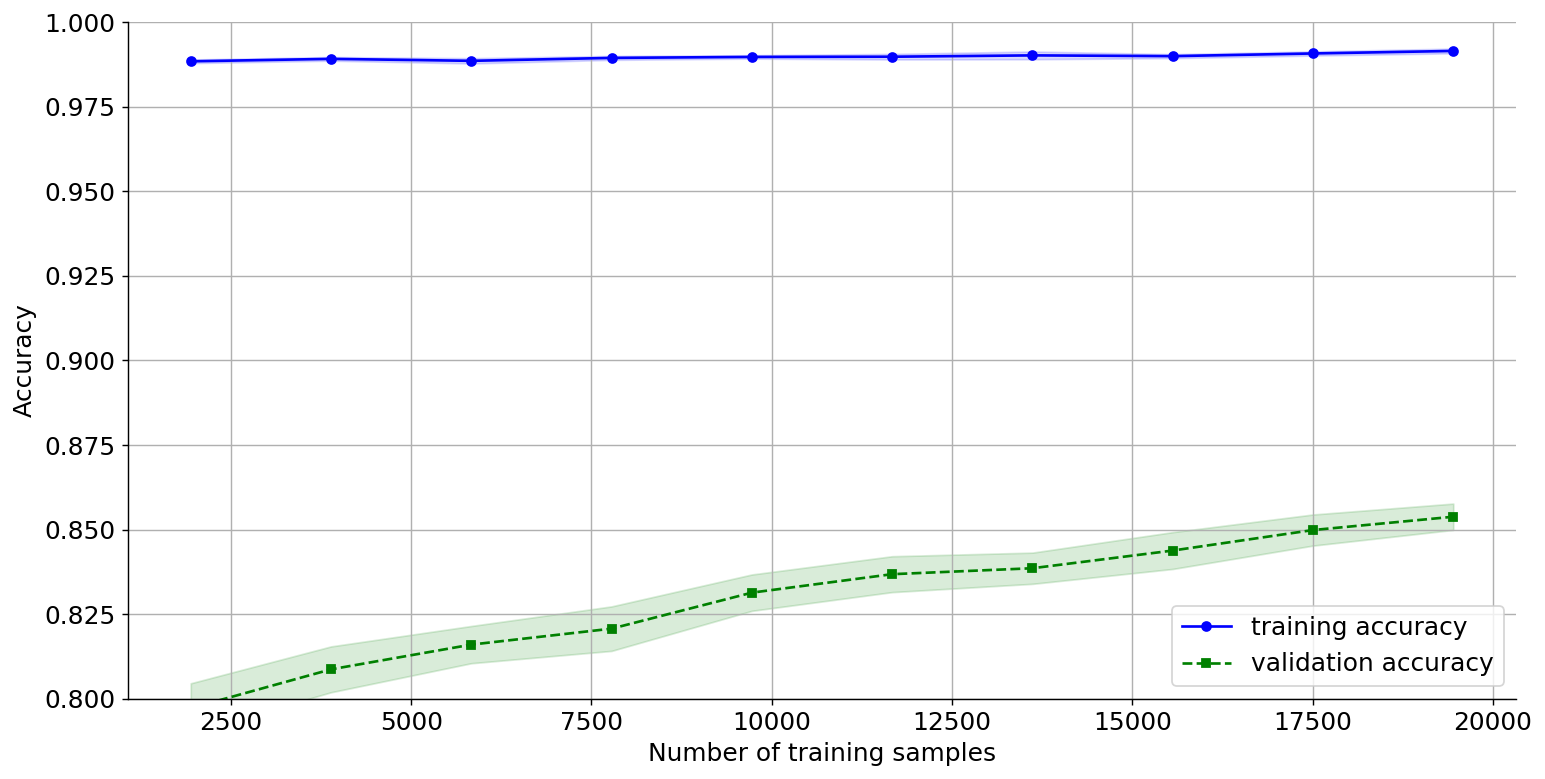

Test Accuracy: 0.854


In [13]:
from sklearn.ensemble import RandomForestClassifier

pipe_rn = make_pipeline(StandardScaler(),PCA(n_components=2),RandomForestClassifier(random_state=1))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_rn,
                                                        X=X_train,y=y_train,train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores, axis=1)      
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')               
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

pipe_rn.fit(X_train, y_train)
y_rn_pred = pipe_rn.predict(X_test)
print('Test Accuracy: %.3f' % pipe_rn.score(X_test, y_test))

In [14]:
from sklearn import cross_validation
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score


scores = cross_validation.cross_val_score(pipe_lr, X, y, cv=3)
print("cross_validation: {:.2f}".format(np.mean(scores, axis=0)))
print("f1 score: {:.2f}".format(f1_score(y_test, y_pred,average='weighted')))
print("precision score: {:.2f}".format(precision_score(y_test, y_pred, average='weighted')))

print()
scores = cross_validation.cross_val_score(pipe_rn, X, y, cv=3)
print("cross_validation: {:.2f}".format(np.mean(scores, axis=0)))
print("f1 score: {:.2f}".format(f1_score(y_test, y_rn_pred,average='weighted')))
print("precision score: {:.2f}".format(precision_score(y_test, y_rn_pred, average='weighted')))
# print()

# scores = cross_validation.cross_val_score(pipe_svm, X_new, y, cv=3)
# print("cross_validation: {:.2f}".format(np.mean(scores, axis=0)))
# print("f1 score: {:.2f}".format(f1_score(y_test, svm_y_pred,average='weighted')))
# print("precision score: {:.2f}".format(precision_score(y_test, svm_y_pred, average='weighted')))

cross_validation: 0.85
f1 score: 0.79
precision score: 0.73

cross_validation: 0.77
f1 score: 0.84
precision score: 0.83


In [15]:
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

# rescale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rfc = RandomForestClassifier(n_estimators=500,random_state=1)
rfc.fit(X_train_scaled, y_train)
pred_forest = rfc.predict(X_test)

print("Test score: {:.2f}".format(rfc.score(X_test_scaled, y_test)))


Test score: 0.91


 1) Loan Amount                    0.116222
 2) Suburb                         0.115216
 3) Enquired                       0.110215
 4) Post Code                      0.108946
 5) Marketing Code                 0.105810
 6) loan_reason                    0.092459
 7) Day                            0.075470
 8) hour                           0.073703
 9) Classification                 0.057245
10) Weekday                        0.045939
11) Month                          0.036924
12) property_use                   0.034313
13) State                          0.027537
14) Year                           0.000000


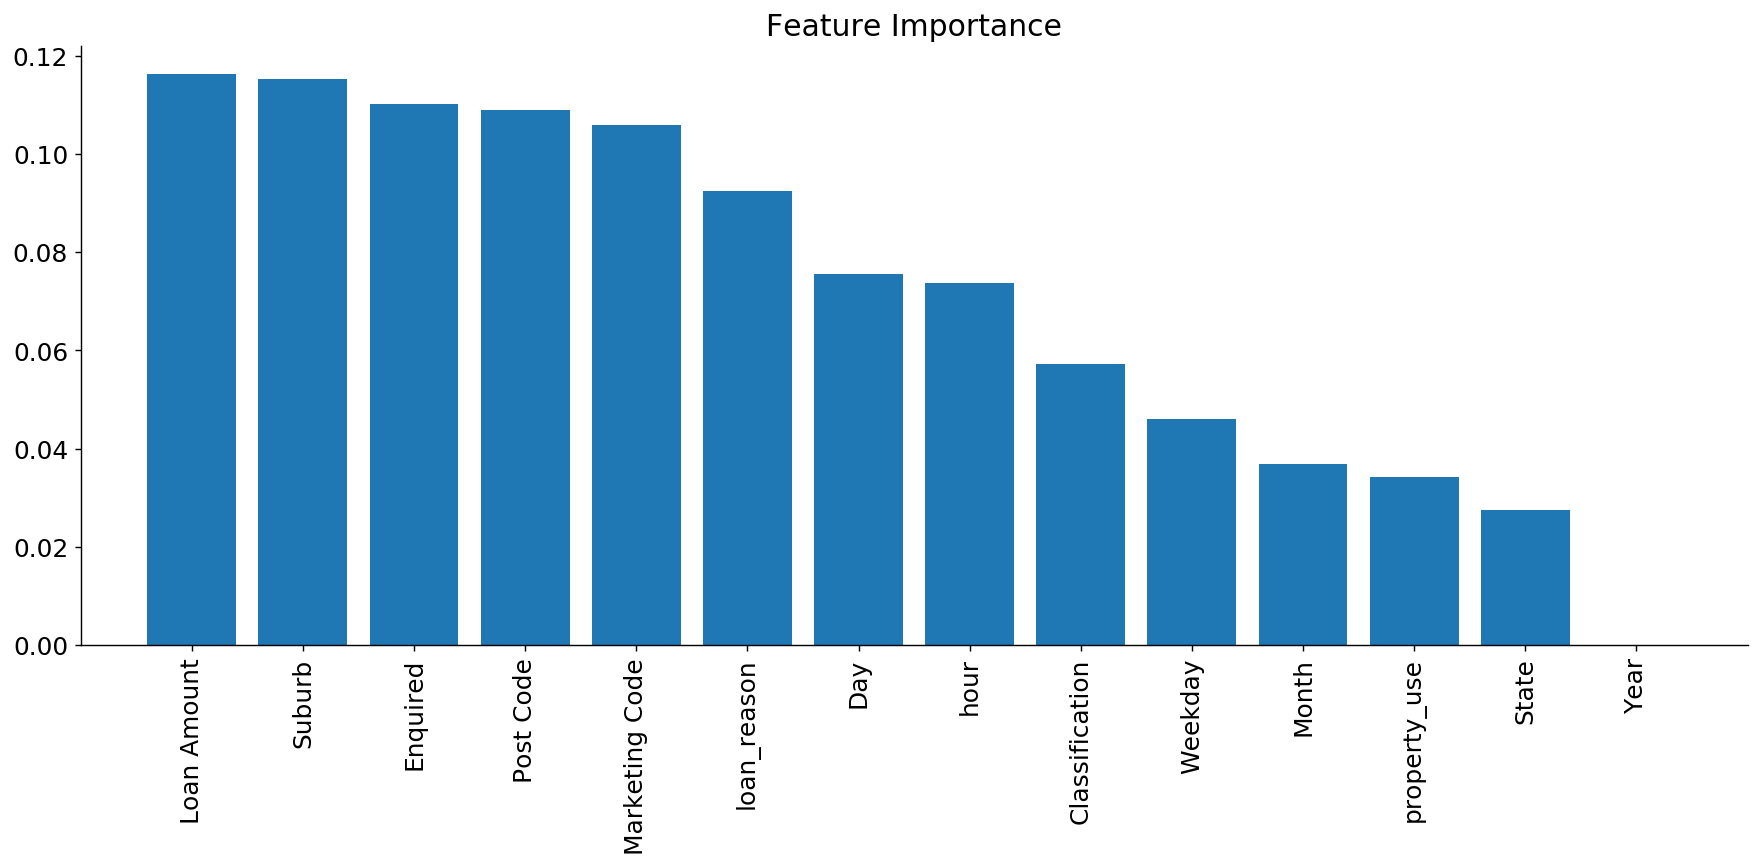

In [16]:
feat_labels = X.columns[0:]
importances = rfc.feature_importances_

# reverse the list
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]],importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),importances[indices],align='center')
plt.xticks(range(X_train.shape[1]),feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [17]:
# input_x = df.iloc[:]
# input_x_test = df.iloc[:,idxs_selected]

# input_x_test = MultiColumnLabelEncoder(columns = input_x_test.keys()).fit_transform(input_x_test)
# input_x_test = scaler.fit_transform(input_x_test)

# result = rfc.predict(input_x_test)
# result = le.inverse_transform(result)
# proba = rfc.predict_proba(input_x_test)   
# proba = [np.max(p) for p in proba]

In [18]:
# input_x = input_x.assign(predict=result.tolist())
# input_x = input_x.assign(possibility=proba)
# input_x.to_csv('example_pipeline.csv')

In [19]:
# import pickle
# import os

# dest = os.path.join('movieclassifier', 'pkl_objects')
# if not os.path.exists(dest):
#     os.makedirs(dest)

# pickle.dump(stop,open(os.path.join(dest, 'stopwords.pkl'),'wb'),protocol=4)
# pickle.dump(clf,
            
from sklearn.externals import joblib
joblib.dump(pipe_lr, 'app/models/lrpipeline.pkl')

['app/models/lrpipeline.pkl']

In [20]:
model_columns = list(X.columns)
joblib.dump(model_columns, 'app/models/model_columns.pkl')

['app/models/model_columns.pkl']

In [21]:
clf = joblib.load('app/models/lrpipeline.pkl')
model_columns = joblib.load('app/models/model_columns.pkl')

In [22]:
data = "[\n  {\n    \"Marketing Code\": \"A9301\",\n    \"Classification\": \"Folio\",\n    \"Enquired\": \"27/10/14 18:53\",\n    \"Loan Amount\": 485000,\n    \"Suburb\": \"BYRON BAY\",\n    \"State\": \"NSW\",\n    \"Post Code\": 2481,\n    \"loan_reason\": \"First HomeBuyer\",\n    \"property_use\": \"Residence\"\n  },\n  {\n    \"Marketing Code\": \"P00019\",\n    \"Classification\": \"Domain Campaigns\",\n    \"Enquired\": \"15/5/15 10:26\",\n    \"Loan Amount\": 500000,\n    \"Suburb\": \"Sydney\",\n    \"State\": \"NSW\",\n    \"Post Code\": 2000,\n    \"loan_reason\": \"Refinance\",\n    \"property_use\": \"Residence\"\n  },\n  {\n    \"Marketing Code\": \"P00019\",\n    \"Classification\": \"Domain Campaigns\",\n    \"Enquired\": \"19/6/15 8:25\",\n    \"Loan Amount\": 500000,\n    \"Suburb\": \"Homebush West\",\n    \"State\": \"NSW\",\n    \"Post Code\": 2140,\n    \"loan_reason\": \"First HomeBuyer\",\n    \"property_use\": \"Residence\"\n  }\n]"

In [23]:
test = pd.read_json(data, orient='records')
query = pd.get_dummies(test)

In [24]:
print(test.dtypes)
mce.transform(test)
display(test)

Classification    object
Enquired          object
Loan Amount        int64
Marketing Code    object
Post Code          int64
State             object
Suburb            object
loan_reason       object
property_use      object
dtype: object


ValueError: y contains new labels: ['P00019']

In [ ]:
y = clf.predict(test)